# Using Presto for a downstream task

Presto is a lightweight foundation model for Earth Observation pixel timeseries.
The purpose of this notebook is to demonstrate how Presto (and utility functions in the Presto package) can be used to make predictions for a downstream task.

To demonsrate the usefulness of Presto even when the input looks very different then what Presto was pre-trained on, we will consider tree-type mapping using single-timestep images.

To do this, we will use the [TreeSat](https://essd.copernicus.org/articles/15/681/2023/) benchmark dataset. This tutorial requires the S2 data to be downloaded from [Zenodo](https://zenodo.org/record/6780578) and unzipped in the [treesat folder](data/treesat).

This notebook is taken from https://github.com/nasaharvest/presto, with some changes. Thanks to all the contributors of the Presto repo!

Follow along to get started!

But before save your own copy (_File->Save a copy in Drive_) and
CHANGE THE RUNTIME TYPE to GPU

---

## 🎓 Notebook by Gabriel Tseng & Ruben Cartuyvels

### Got questions or innovative ideas? Drop a message at Ruben.Cartuyvels@esa.int

---

## Let's Start! 🛰️

---


## Setting up ...

In [1]:
!git clone https://github.com/nasaharvest/presto
%cd presto

Cloning into 'presto'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 398 (delta 82), reused 72 (delta 72), pack-reused 262 (from 1)
Receiving objects: 100% (398/398), 18.03 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/content/presto


In [2]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [3]:
import h5py
print(h5py.__version__)
import torch
print(torch.__version__)

3.14.0
2.8.0+cu126


Execute the following, ignore the warnings, restart the session as the pop-up asks. Then continue from the next cell.

In [2]:
!pip install webdataset "hurry.filesize" "openmapflow[data]" "numpy==1.26.0"
# !pip install webdataset "hurry.filesize" "openmapflow[data]" # "numpy>=2.0"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of geopandas to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.5/827.5 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Download the TreeSat Sentinel-2 data from Zenodo and extract the .zip file:

In [2]:
!wget -P /content/presto/data/treesat/ https://zenodo.org/records/6598391/files/s2.zip
!unzip -q /content/presto/data/treesat/s2.zip -d /content/presto/data/treesat/

--2025-09-11 15:23:04--  https://zenodo.org/records/6598391/files/s2.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510023289 (486M) [application/octet-stream]
Saving to: ‘/content/presto/data/treesat/s2.zip’

s2.zip              100%[===================>] 486.40M  2.89MB/s    in 3m 25s  

2025-09-11 15:26:30 (2.37 MB/s) - ‘/content/presto/data/treesat/s2.zip’ saved [510023289/510023289]



## 1. Processing the data

In [1]:
import xarray
from pyproj import Transformer
import numpy as np
from scipy import stats
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, TensorDataset

# this is to silence the xarray deprecation warning.
# Our version of xarray is pinned, but we'll need to fix this
# when we upgrade
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
!pip uninstall presto
!pip install -e /content/presto --no-deps

Found existing installation: presto 0.0.1
Uninstalling presto-0.0.1:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/__editable__.presto-0.0.1.pth
    /usr/local/lib/python3.12/dist-packages/__editable___presto_0_0_1_finder.py
    /usr/local/lib/python3.12/dist-packages/presto-0.0.1.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled presto-0.0.1
Obtaining file:///content/presto
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for presto (pyproject.toml) ... done
  Created wheel for presto: filename=presto-0.0.1-0.editable-py3-none-any.whl size=7422 sha256=4013bf2e6f4777c5ceacaa0bc52a64a015b90229c2ccad312bd38aefa596cc68
  Stored in directory: /tmp/pip-ephem-wheel-cache-93bxtj80/wheels/78/b3/e8/1ddb0899f29314c6870bb313eedfd82bdb99e9fd619c89f8eb
Successfully built presto


If the TreeSat data has been correctly downloaded from Zenodo (see the Markdown cell above), these assert statements should pass.

If the import from presto does not work, you might have to re-run the block above that contains `!pip install -e /content/presto --no-deps` (and the preceeding cell after restarting the session, if necessary).

In [2]:
# from presto import presto
from presto import utils
from pathlib import Path

treesat_folder = Path('/content/presto') / utils.data_dir / "treesat"
assert treesat_folder.exists()

# this folder should exist once the s2 file from zenodo has been unzipped
s2_data_60m = treesat_folder / "s2/60m"
assert s2_data_60m.exists()

For simplicity, we will only consider classification between 2 tree species: Abies_alba and Acer_pseudoplatanus.

The TreeSatAI S2 data contains the following bands: ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B11", "B12", "B1", "B9"]

In [3]:
TREESATAI_S2_BANDS = ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B11", "B12", "B1", "B9"]

SPECIES = ["Abies_alba", "Acer_pseudoplatanus"]
NUM_CLASSES = len(SPECIES)

In [4]:
# We subsample a 3x3 grid of pixels
INDICES_IN_TIF_FILE = list(range(0, 6, 2))

with (treesat_folder / "train_filenames.lst").open("r") as f:
    train_files = [line for line in f if (line.startswith(SPECIES[0]) or line.startswith(SPECIES[1]))]
with (treesat_folder / "test_filenames.lst").open("r") as f:
    test_files = [line for line in f if (line.startswith(SPECIES[0]) or line.startswith(SPECIES[1]))]

print(f"{len(train_files)} train files and {len(test_files)} test files")

3430 train files and 375 test files


In [5]:
first_filename = train_files[0]
tif_file = xarray.open_rasterio(s2_data_60m / first_filename.strip())
print("The tif file looks like this:\n", tif_file)

The tif file looks like this:
 <xarray.DataArray (band: 12, y: 6, x: 6)>
array([[[  97,   93, ...,   90,  101],
        [  93,  104, ...,   85,   93],
        ...,
        [  79,   77, ...,  106,   93],
        [ 129,  108, ...,  141,  119]],

       [[ 176,  199, ...,  220,  220],
        [ 222,  212, ...,  214,  207],
        ...,
        [ 172,  172, ...,  216,  226],
        [ 246,  263, ...,  313,  309]],

       ...,

       [[ 112,   96, ...,  117,   99],
        [ 117,  102, ...,  127,  110],
        ...,
        [ 116,  102, ...,  134,  118],
        [ 122,  106, ...,  134,  117]],

       [[1625, 1624, ..., 1634, 1643],
        [1616, 1601, ..., 1625, 1604],
        ...,
        [1617, 1603, ..., 1626, 1614],
        [1621, 1610, ..., 1629, 1616]]], dtype=uint16)
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * y        (y) float64 5.728e+06 5.728e+06 5.728e+06 ... 5.728e+06 5.728e+06
  * x        (x) float64 5.522e+05 5.523e+05 5.523e+05 ... 5.523e+05 5.

We can see that it is a 12-band 6-by-6 pixel image with longitude (x) and latitude (y) coordinates. Let's plot it.

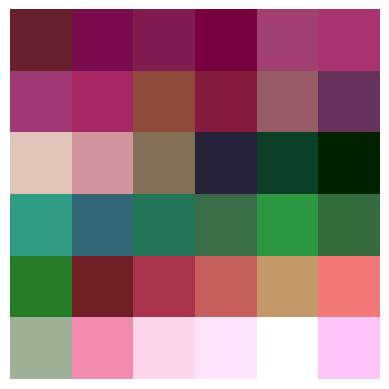

In [6]:
def normalize(image, alpha=0.13, beta=0.0):
    rgb_image = np.clip(alpha*image + beta, 0, 255)
    band_min, band_max = rgb_image.reshape(3, -1).min(axis=1), rgb_image.reshape(3, -1).max(axis=1)
    rgb_image = (rgb_image - band_min[...,None,None]) / (band_max - band_min)[...,None,None]
    return rgb_image

rgb_image = tif_file.sel(band=[4, 3, 2]).data
rgb_image = normalize(rgb_image)

import matplotlib.pyplot as plt
plt.imshow(rgb_image.transpose(1, 2, 0))
plt.axis("off")
plt.show()

We use `presto.construct_single_presto_input` to transform the TreeSat S2 data into the tensors expected by Presto.

In [17]:
from presto import presto

def process_images(filenames):
    # takes a (6, 6) treesat tif file, and returns a
    # (9,1,18) data tensor (with all bands "masked" except for S1 and S2)
    arrays, masks, latlons, image_names, labels, dynamic_worlds = [], [], [], [], [], []

    for filename in tqdm(filenames):
        tif_file = xarray.open_rasterio(s2_data_60m / filename.strip())
        transformer = Transformer.from_crs(tif_file.crs, "EPSG:4326", always_xy=True)

        for x_idx in INDICES_IN_TIF_FILE:
            for y_idx in INDICES_IN_TIF_FILE:

                # first, get the latitudes and longitudes
                x, y = tif_file.x[x_idx], tif_file.y[y_idx]
                lon, lat = transformer.transform(x, y)
                latlons.append(torch.tensor([lat, lon]))

                # then, get the eo_data, mask and dynamic world
                s2_data_for_pixel = torch.from_numpy(tif_file.values[:, x_idx, y_idx].astype(int)).float()
                s2_data_with_time_dimension = s2_data_for_pixel.unsqueeze(0)
                x, mask, dynamic_world = presto.construct_single_presto_input(
                    s2=s2_data_with_time_dimension, s2_bands=TREESATAI_S2_BANDS
                )
                arrays.append(x)
                masks.append(mask)
                dynamic_worlds.append(dynamic_world)

                labels.append(0 if filename.startswith("Abies") else 1)
                image_names.append(filename)

    return (torch.stack(arrays, axis=0),
            torch.stack(masks, axis=0),
            torch.stack(dynamic_worlds, axis=0),
            torch.stack(latlons, axis=0),
            torch.tensor(labels),
            image_names,
        )

In [18]:
train_data = process_images(train_files)
test_data = process_images(test_files)
print("\n", train_data[0].shape)  # this will give [N_pixels, N_timesteps, N_bands]

  0%|          | 0/3430 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]


 torch.Size([30870, 1, 17])


## 2. Finetuning Presto with a classification head

We define some hyperparameters

In [19]:
import torch

lr: float = 3e-4
max_epochs: int = 5
batch_size: int = 64
patience: int = 3
num_workers: int = 2
weight_decay: float = 0.05

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

Then we give the pretrained model a classification head.

In [20]:
from presto.presto import PrestoFineTuningModel
from presto.model import FinetuningHead

# Build model
pretrained_model = presto.Presto.construct()
pretrained_model.load_state_dict(torch.load(Path("/content/presto/data/default_model.pt"), map_location=device))

# Hack around a bit so it works both on CPU and GPU
torch.save(pretrained_model.to('cpu').state_dict(), '/content/presto/data/default_model_cpu.pt')

if device.type == 'cpu':
  pretrained_model.load_state_dict(torch.load(Path("/content/presto/data/default_model_cpu.pt")))

pretrained_model = pretrained_model.to(device)

# Attach the classification head that we'll finetune
head = FinetuningHead(
    num_outputs=NUM_CLASSES,
    hidden_size=pretrained_model.encoder.embedding_size,
    regression=False,
)
model = PrestoFineTuningModel(pretrained_model.encoder, head)
model = model.to(device)
model.train()

PrestoFineTuningModel(
  (encoder): Encoder(
    (eo_patch_embed): ModuleDict(
      (S1): Linear(in_features=2, out_features=128, bias=True)
      (S2_RGB): Linear(in_features=3, out_features=128, bias=True)
      (S2_Red_Edge): Linear(in_features=3, out_features=128, bias=True)
      (S2_NIR_10m): Linear(in_features=1, out_features=128, bias=True)
      (S2_NIR_20m): Linear(in_features=1, out_features=128, bias=True)
      (S2_SWIR): Linear(in_features=2, out_features=128, bias=True)
      (ERA5): Linear(in_features=2, out_features=128, bias=True)
      (SRTM): Linear(in_features=2, out_features=128, bias=True)
      (NDVI): Linear(in_features=1, out_features=128, bias=True)
    )
    (dw_embed): Embedding(10, 128)
    (latlon_embed): Linear(in_features=3, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=

Define the optimizer and loss function.

In [21]:
from torch.optim import AdamW
from torch import nn
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss(reduction="mean")

We split the training data into a train and validation set and construct the dataloaders.

In [22]:
# the treesat AI data was collected during the summer,
# so we estimate the month to be 6 (July)
month = torch.tensor([6] * train_data[0].shape[0]).long()

full_ds = TensorDataset(
    train_data[0].float(),  # x
    # train_data[1].bool(),  # mask
    train_data[2].long(),  # dynamic world
    train_data[3].float(),  # latlons
    train_data[4].long(),  # labels
    month
)
train_ds, val_ds = torch.utils.data.random_split(full_ds, [0.9, 0.1])
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [23]:
model.encoder.eo_patch_embed.S1.weight.data.device

device(type='cuda', index=0)

Now we run the train and val loop. ideally, we expect the train and validation loss to both go down.

In [24]:
from copy import deepcopy

train_loss = []
val_loss = []
best_loss = None
best_model_dict = None
epochs_since_improvement = 0

for _ in (pbar := tqdm(range(max_epochs), desc="Finetuning epoch")):
    model.train()
    epoch_train_loss = 0.0
    for x, dw, latlons, y, month in tqdm(train_dl, desc="Batches", leave=False):
        x, dw, latlons, y, month = [t.to(device) for t in (x, dw, latlons, y, month)]
        optimizer.zero_grad()
        preds = model(
            x,
            dynamic_world=dw,
            mask=None,
            latlons=latlons,
            month=month,
        )
        loss = loss_fn(preds, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(epoch_train_loss / len(train_dl))

    model.eval()
    all_preds, all_y = [], []
    for x, dw, latlons, y, month in val_dl:
        x, dw, latlons, y, month = [t.to(device) for t in (x, dw, latlons, y, month)]
        with torch.no_grad():
            preds = model(
                x,
                dynamic_world=dw,
                mask=None,
                latlons=latlons,
                month=month,
            )
            all_preds.append(preds)
            all_y.append(y)

    val_loss.append(loss_fn(torch.cat(all_preds), torch.cat(all_y)))
    pbar.set_description(f"Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}")
    if best_loss is None:
        best_loss = val_loss[-1]
        best_model_dict = deepcopy(model.state_dict())
    else:
        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            best_model_dict = deepcopy(model.state_dict())
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            if epochs_since_improvement >= patience:
                print("Early stopping!")
                break
assert best_model_dict is not None
model.load_state_dict(best_model_dict)

model.eval()


Finetuning:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

Training:   0%|          | 0/435 [00:00<?, ?it/s]

PrestoFineTuningModel(
  (encoder): Encoder(
    (eo_patch_embed): ModuleDict(
      (S1): Linear(in_features=2, out_features=128, bias=True)
      (S2_RGB): Linear(in_features=3, out_features=128, bias=True)
      (S2_Red_Edge): Linear(in_features=3, out_features=128, bias=True)
      (S2_NIR_10m): Linear(in_features=1, out_features=128, bias=True)
      (S2_NIR_20m): Linear(in_features=1, out_features=128, bias=True)
      (S2_SWIR): Linear(in_features=2, out_features=128, bias=True)
      (ERA5): Linear(in_features=2, out_features=128, bias=True)
      (SRTM): Linear(in_features=2, out_features=128, bias=True)
      (NDVI): Linear(in_features=1, out_features=128, bias=True)
    )
    (dw_embed): Embedding(10, 128)
    (latlon_embed): Linear(in_features=3, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=

And the test loop...

In [25]:
# the treesat AI data was collected during the summer,
# so we estimate the month to be 6 (July)
month = torch.tensor([6] * test_data[0].shape[0]).long()

test_dl = DataLoader(
    TensorDataset(
        test_data[0].float(),  # x
        test_data[1].bool(),  # mask
        test_data[2].long(),  # dynamic world
        test_data[3].float(),  # latlons
        month
    ),
    batch_size=batch_size,
    shuffle=False,
)

In [29]:
test_preds = []
for (x, mask, dw, latlons, month) in tqdm(test_dl):
    with torch.no_grad():
        model.eval()
        x, dw, latlons, y, month = [t.to(device) for t in (x, dw, latlons, y, month)]
        preds = model(
            x,
            dynamic_world=dw,
            mask=None,
            latlons=latlons,
            month=month,
        )
        test_preds.append(preds.cpu())

pix_per_image = len(INDICES_IN_TIF_FILE) ** 2

test_preds_np = np.concatenate(test_preds, axis=0)
test_preds_np = np.reshape(
    test_preds_np,
    (int(len(test_preds_np) / pix_per_image), pix_per_image, test_preds_np.shape[-1]),
)
# then, take the mode of the model predictions
test_preds_np_argmax = stats.mode(
    np.argmax(test_preds_np, axis=-1), axis=1, keepdims=False
)[0]

  0%|          | 0/53 [00:00<?, ?it/s]

In [30]:
target = np.reshape(test_data[4], (int(len(test_data[4]) / pix_per_image), pix_per_image))[:, 0]

f1_score(target, test_preds_np_argmax, average="weighted")

0.9627988188082078

## 3. Using Presto as a feature extractor for a random forest (skip if no time)

One way to use Presto is as a feature extractor for a simple model (e.g. a Random Forest). We do this below.

We load the pretrained Presto model using `Presto.load_pretrained()`.

In [35]:
batch_size = 64

# Build model
pretrained_model = presto.Presto.construct()
pretrained_model.load_state_dict(torch.load(Path("/content/presto/data/default_model.pt"), map_location=device))

# Hack around a bit so it works both on CPU and GPU
torch.save(pretrained_model.to('cpu').state_dict(), '/content/presto/data/default_model_cpu.pt')

if device.type == 'cpu':
  pretrained_model.load_state_dict(torch.load(Path("/content/presto/data/default_model_cpu.pt")))

pretrained_model = pretrained_model.to(device)

We will start by constructing features for the training data, and using this to train a Random Forest.

In [36]:
# the treesat AI data was collected during the summer,
# so we estimate the month to be 6 (July)
month = torch.tensor([6] * train_data[0].shape[0]).long()

train_dl = DataLoader(
    TensorDataset(
        train_data[0].float(),  # x
        train_data[1].bool(),  # mask
        train_data[2].long(),  # dynamic world
        train_data[3].float(),  # latlons
        month
    ),
    batch_size=batch_size,
    shuffle=False,
)

Note that we only use the Presto encoder (`pretrained_model.encoder`), since this is the part that computes informative embedding features.

In [38]:
features_list = []
for (x, mask, dw, latlons, month) in tqdm(train_dl):
    with torch.no_grad():
        x, dw, latlons, y, month = [t.to(device) for t in (x, dw, latlons, y, month)]
        encodings = (
            pretrained_model.encoder(
                x, dynamic_world=dw, mask=None, latlons=latlons, month=month
            )
            .cpu()
            .numpy()
        )
        features_list.append(encodings)
features_np = np.concatenate(features_list)

  0%|          | 0/483 [00:00<?, ?it/s]

We use `features_np` to train a Random Forest classifier (with scikit-learn):

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_model.fit(features_np, train_data[4].numpy())

RandomForestClassifier(class_weight='balanced', random_state=42)

We can then use this trained random forest to make some predictions on the test data.

In [40]:
# the treesat AI data was collected during the summer,
# so we estimate the month to be 6 (July)
month = torch.tensor([6] * test_data[0].shape[0]).long()

test_dl = DataLoader(
    TensorDataset(
        test_data[0].float(),  # x
        test_data[1].bool(),  # mask
        test_data[2].long(),  # dynamic world
        test_data[3].float(),  # latlons
        month
    ),
    batch_size=batch_size,
    shuffle=False,
)

In [41]:
test_preds = []
for (x, mask, dw, latlons, month) in tqdm(test_dl):
    with torch.no_grad():
        x, dw, latlons, y, month = [t.to(device) for t in (x, dw, latlons, y, month)]
        pretrained_model.eval()
        encodings = (pretrained_model.encoder(
            x, dynamic_world=dw, mask=None, latlons=latlons, month=month)
            .cpu()
            .numpy()
        )
        test_preds.append(rf_model.predict_proba(encodings))

  0%|          | 0/53 [00:00<?, ?it/s]

We take the mode of the 9 pixels we processed for a single image

In [42]:
pix_per_image = len(INDICES_IN_TIF_FILE) ** 2

test_preds_np = np.concatenate(test_preds, axis=0)
test_preds_np = np.reshape(
    test_preds_np,
    (int(len(test_preds_np) / pix_per_image), pix_per_image, test_preds_np.shape[-1]),
)
# then, take the mode of the model predictions
test_preds_np_argmax = stats.mode(
    np.argmax(test_preds_np, axis=-1), axis=1, keepdims=False
)[0]

And finally, we can compute the F1 score of the test predictions.

In [43]:
target = np.reshape(test_data[4], (int(len(test_data[4]) / pix_per_image), pix_per_image))[:, 0]

f1_score(target, test_preds_np_argmax, average="weighted")

0.9655157739863621

The predictions are pretty accurate, even with a frozen encoder computing input features for a random forest classifier!
(Even more accurate in this case than finetuning the entire model with a linear CLF head.)